# Recommendations with IBM

This notebook produces recommendations for users from real data on the IBM Watson Studio platform. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering/Content based](#User-User)<br>
IV. [Matrix Factorization](#Matrix-Fact)<br>
V. [Extras & Concluding](#conclusions)


In [1]:
import sys
sys.path.insert(0, './tests')
sys.path.insert(0, './data')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle

%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [2]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

 

In [3]:
num_articles = len(df.article_id.unique())
print('Number of unique articles = {}'.format(num_articles))
num_rows = df.shape[0] 
print('Number of rows in df = {}'.format(num_rows))
num_articles_content = len(df_content.article_id.unique())
print('Number of unique articles in df_content = {}'.format(num_articles_content))
num_rows_content = df_content.shape[0] 
print('Number of rows in df_content = {}'.format(num_rows_content))

df_unique = df.article_id.astype(int).unique()
df_content_unique = df_content.article_id.astype(int).unique()

print('Unique number of users = {}'.format(len(df.email.unique())))

num = len(df_content_unique[np.isin(df_content_unique, df_unique)])
print('Number of unique articles in interactions and community = {}'.format(num))
print('Mean article interactions = {}'.format(df.article_id.value_counts().mean()))
print('Median article interactions = {}'.format(df.article_id.value_counts().median()))
print('Mean user interactions = {}'.format(df.email.value_counts().mean()))
print('Median user interactions = {}'.format(df.email.value_counts().median()))

print('Top interactors\n')
print(df.email.value_counts().head(15))
print('Top articles\n')
print(df.article_id.value_counts().head(15))


df.email.value_counts().median()

Number of unique articles = 714
Number of rows in df = 45993
Number of unique articles in df_content = 1051
Number of rows in df_content = 1056
Unique number of users = 5149
Number of unique articles in interactions and community = 437
Mean article interactions = 64.41596638655462
Median article interactions = 25.0
Mean user interactions = 8.930846930846931
Median user interactions = 3.0
Top interactors

2b6c0f514c2f2b04ad3c4583407dccd0810469ee    364
77959baaa9895a7e2bdc9297f8b27c1b6f2cb52a    363
2f5c7feae533ce046f2cb16fb3a29fe00528ed66    170
a37adec71b667b297ed2440a9ff7dad427c7ac85    169
8510a5010a5d4c89f5b07baac6de80cd12cfaf93    160
f8c978bcf2ae2fb8885814a9b85ffef2f54c3c76    158
284d0c17905de71e209b376e3309c0b08134f7e2    148
d9032ff68d0fd45dfd18c0c5f7324619bb55362c    147
18e7255ee311d4bd78f5993a9f09538e459e3fcc    147
276d9d8ca0bf52c780b5a3fc554fa69e74f934a3    145
c60bb0a50c324dad0bffd8809d121246baef372b    145
56832a697cb6dbce14700fca18cffcced367057f    144
b2d2c70ed5de62cf

3.0

In [4]:
# Filling the median and maximum number of user_article interactios below

median_val =df.email.value_counts().median() 
max_views_by_user = df.email.value_counts().head(1).values[0]

Explore and remove duplicate articles from the **df_content** dataframe.  

In [5]:
# Find and explore duplicate articles
df_content[df_content.doc_body.duplicated()].shape[0]

19

In [6]:
# Find and explore duplicate article descriptioin
df_content[df_content.doc_description.duplicated()].shape[0]

33

In [7]:
# Find and explore duplicate article doc full name
df_content[df_content.doc_full_name.duplicated()].shape[0]

5

In [8]:
# Find and explore duplicate article ids
df_content[df_content.article_id.duplicated()].shape[0]

5

In [9]:
# Remove any rows that have the same article_id - only keep the first
df_content = df_content.drop_duplicates('article_id', keep = 'first')
df_content.shape[0]

1051

In [10]:
# Find and explore duplicate document descriptions
c = df_content[df_content.doc_description.duplicated()].doc_body
c.head(50)

76      ☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...
78      ☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...
87      Beta ☰ * Login\r\n * Sign Up\r\n\r\n * Learnin...
113     ☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...
136     ☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...
191     ☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...
210     ☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...
269     ☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...
288     ☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...
304     ☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...
348     ☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...
441     ☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...
449     ☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...
462     ☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...
492     ☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...
493     * Home\r\n * Research\r\n * Partnerships and C...
503     Beta ☰ * Login\r\n * Sign Up\r\n\r\n * Learnin...
560     ☰ * Lo

In [11]:
unique_articles = df.article_id.nunique()# The number of unique articles that have at least one interaction
total_articles = df_content.article_id.nunique()# The number of unique articles on the IBM platform
unique_users =  df.email.nunique()# The number of unique users
user_article_interactions = df.shape[0]# The number of user-article interactions

Finding the most viewed article ID

In [12]:
df[df.email.isnull()].head()

,article_id,title,email
25131,1016.0,why you should master r (even if it might even...,NaN
29758,1393.0,the nurse assignment problem,NaN
29759,20.0,working interactively with rstudio and noteboo...,NaN
29760,1174.0,breast cancer wisconsin (diagnostic) data set,NaN
29761,62.0,data visualization: the importance of excludin...,NaN


In [13]:
df[df.article_id == 1024.0]

,article_id,title,email
2734,1024.0,using deep learning to reconstruct high-resolu...,11852f6327839440b11c155fdb27defbbfa79786
3086,1024.0,using deep learning to reconstruct high-resolu...,2f5c7feae533ce046f2cb16fb3a29fe00528ed66
3954,1024.0,using deep learning to reconstruct high-resolu...,ad7fa909739c58e0a574e65f039b9b7b6dd6d288
4127,1024.0,using deep learning to reconstruct high-resolu...,76afb470ac47659165a601c6417ac5e303eaa982
4486,1024.0,using deep learning to reconstruct high-resolu...,c86c2e3d4f2a52a32f4fe815589de45b76d44200
...,...,...,...
42763,1024.0,using deep learning to reconstruct high-resolu...,5762369769eacb15c10da38989a62a3f229ae029
42809,1024.0,using deep learning to reconstruct high-resolu...,9cc6b46eb3772e6552c547edfbbe2c53918c093d
44312,1024.0,using deep learning to reconstruct high-resolu...,0858586c74b67f287452e810d87b127cc45d26a0
45599,1024.0,using deep learning to reconstruct high-resolu...,87fc3a178500e56a288ff40091c8d513706c86e2


In [14]:
# Most viewed article_id
df.article_id.value_counts().sort_values(ascending = False).head(1).index[0]

1429.0

In [15]:
most_viewed_article_id = df.article_id.value_counts().sort_values(ascending = False).head(1).index.astype(str)[0]# The most viewed article in the dataset as a string with one value following the decimal 
max_views = df.article_id.value_counts().sort_values(ascending = False).head(1).values.astype(int)[0]# The most viewed article in the dataset was viewed how many times?

In [16]:
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [17]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Rank based recommendations

In [18]:
#Get list of top article IDs
idx = df.article_id.value_counts().sort_values(ascending = False).head(10).index.to_list()
idx

[1429.0,
 1330.0,
 1431.0,
 1427.0,
 1364.0,
 1314.0,
 1293.0,
 1170.0,
 1162.0,
 1304.0]

In [19]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    idx = df.article_id.value_counts().sort_values(ascending = False).head(n).index
    top_articles = df[df.article_id.isin(idx)]['title'].unique()
    return top_articles # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # Your code here
    top_articles = df.article_id.value_counts().sort_values(ascending = False).head(n).index.to_list()
    return top_articles # Return the top article ids

In [20]:
# Test ranked based functions
print(get_top_article_ids(10))
print(get_top_articles(10))

[1429.0, 1330.0, 1431.0, 1427.0, 1364.0, 1314.0, 1293.0, 1170.0, 1162.0, 1304.0]
['healthcare python streaming application demo'
 'use deep learning for image classification'
 'apache spark lab, part 1: basic concepts'
 'predicting churn with the spss random tree algorithm'
 'analyze energy consumption in buildings'
 'visualize car data with brunel'
 'use xgboost, scikit-learn & ibm watson machine learning apis'
 'gosales transactions for logistic regression model'
 'insights from new york car accident reports'
 'finding optimal locations of new store using decision optimization']


In [21]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


In [22]:
df

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5
...,...,...,...
45988,1324.0,ibm watson facebook posts for 2015,5146
45989,142.0,neural networks for beginners: popular types a...,5146
45990,233.0,bayesian nonparametric models – stats and bots,5147
45991,1160.0,analyze accident reports on amazon emr spark,5148


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [23]:
d = df[['user_id', 'article_id']]
d['value'] = 1
d = d.groupby(['user_id', 'article_id']).max().unstack()
d = d.fillna(0)
d

value                                                          \
article_id 0.0    2.0    4.0    8.0    9.0    12.0   14.0   15.0   16.0     
user_id                                                                     
1             0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
2             0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
3             0.0    0.0    0.0    0.0    0.0    1.0    0.0    0.0    0.0   
4             0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
5             0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
...           ...    ...    ...    ...    ...    ...    ...    ...    ...   
5145          0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
5146          0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
5147          0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
5148          0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
5149          0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    1.0   

                   ...                                                   \
article_id 18.0    ... 1434.0 1435.0 1436.0 1437.0 1439.0 1440.0 1441.0   
user_id            ...                                                    
1             0.0  ...    0.0    0.0    1.0    0.0    1.0    0.0    0.0   
2             0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
3             0.0  ...    0.0    0.0    1.0    0.0    0.0    0.0    0.0   
4             0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
5             0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
...           ...  ...    ...    ...    ...    ...    ...    ...    ...   
5145          0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
5146          0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
5147          0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
5148          0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
5149          0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

                                 
article_id 1442.0 1443.0 1444.0  
user_id                          
1             0.0    0.0    0.0  
2             0.0    0.0    0.0  
3             0.0    0.0    0.0  
4             0.0    0.0    0.0  
5             0.0    0.0    0.0  
...           ...    ...    ...  
5145          0.0    0.0    0.0  
5146          0.0    0.0    0.0  
5147          0.0    0.0    0.0  
5148          0.0    0.0    0.0  
5149          0.0    0.0    0.0  

[5149 rows x 714 columns]

In [24]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    # Fill in the function here
    df = df[['user_id', 'article_id']]
    df['value'] = 1
    df = df.groupby(['user_id', 'article_id']).max().unstack()
    df = df.fillna(0)
    user_item = df
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

In [25]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


Function below should take user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [26]:
user_item

value                                                          \
article_id 0.0    2.0    4.0    8.0    9.0    12.0   14.0   15.0   16.0     
user_id                                                                     
1             0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
2             0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
3             0.0    0.0    0.0    0.0    0.0    1.0    0.0    0.0    0.0   
4             0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
5             0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
...           ...    ...    ...    ...    ...    ...    ...    ...    ...   
5145          0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
5146          0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
5147          0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
5148          0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
5149          0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    1.0   

                   ...                                                   \
article_id 18.0    ... 1434.0 1435.0 1436.0 1437.0 1439.0 1440.0 1441.0   
user_id            ...                                                    
1             0.0  ...    0.0    0.0    1.0    0.0    1.0    0.0    0.0   
2             0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
3             0.0  ...    0.0    0.0    1.0    0.0    0.0    0.0    0.0   
4             0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
5             0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
...           ...  ...    ...    ...    ...    ...    ...    ...    ...   
5145          0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
5146          0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
5147          0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
5148          0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
5149          0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

                                 
article_id 1442.0 1443.0 1444.0  
user_id                          
1             0.0    0.0    0.0  
2             0.0    0.0    0.0  
3             0.0    0.0    0.0  
4             0.0    0.0    0.0  
5             0.0    0.0    0.0  
...           ...    ...    ...  
5145          0.0    0.0    0.0  
5146          0.0    0.0    0.0  
5147          0.0    0.0    0.0  
5148          0.0    0.0    0.0  
5149          0.0    0.0    0.0  

[5149 rows x 714 columns]

In [27]:
# Exploring the IDs of the user_item multiindex 
# Finding similar articles 
dot_prod_articles = user_item.dot(np.transpose(user_item))
print(dot_prod_articles)
idx = np.where(user_item.index == 5145)[0][0]
print(idx)
print('[[[[[[[[[[[[[[[[]]]]]]]]]]]]]]]]')
print(dot_prod_articles.iloc[idx])
print('---------------------------------')
print(np.max(dot_prod_articles.iloc[idx]))

sim_idx= np.where(dot_prod_articles.iloc[idx] == np.max(dot_prod_articles.iloc[idx]))[0]
print(sim_idx)

sim_art = np.array(df[df['user_id'].isin(sim_idx)]['title'])
sim_art

user_id  1     2     3     4     5     6     7     8     9     10    ...  \
user_id                                                              ...   
1        36.0   2.0   6.0   3.0   0.0   4.0   1.0   6.0   4.0   7.0  ...   
2         2.0   6.0   1.0   3.0   0.0   2.0   0.0   1.0   2.0   4.0  ...   
3         6.0   1.0  40.0   5.0   1.0   7.0   1.0   5.0   2.0   5.0  ...   
4         3.0   3.0   5.0  26.0   3.0   8.0   0.0   8.0   1.0   4.0  ...   
5         0.0   0.0   1.0   3.0   3.0   1.0   0.0   3.0   0.0   0.0  ...   
...       ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   
5145      1.0   1.0   2.0   2.0   0.0   0.0   0.0   0.0   0.0   1.0  ...   
5146      0.0   0.0   0.0   1.0   0.0   1.0   0.0   1.0   0.0   0.0  ...   
5147      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
5148      0.0   0.0   0.0   1.0   0.0   0.0   0.0   1.0   0.0   0.0  ...   
5149      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0   0.0  ...   

user_id  51

array(['nips 2016 — day 2 highlights',
       'a dynamic duo – inside machine learning – medium',
       'how to choose a project to practice data science',
       'maximize oil company profits', 'maximize oil company profits',
       'use decision optimization to schedule league games',
       'maximize oil company profits', 'the nurse assignment problem',
       'a comparison of logistic regression and naive bayes ',
       'learning statistics on youtube'], dtype=object)

In [28]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # find row of each user
    idx = np.where(user_item.index == user_id)[0][0]
    # compute similarity of each user to the provided user
    dot_prod_articles = user_item.dot(np.transpose(user_item))
    sim = dot_prod_articles.iloc[idx].sort_values(ascending = False)
    print(sim)
    # sort by similarity
    sim = sim[sim.values > 0]
    # create list of just the ids
    sim = sim.index.drop(user_id)
    # remove the own user's id
    most_similar_users = sim.to_list()
       
    return most_similar_users # return a list of the users in order from most to least similar
        

In [29]:
# Exploring similar users
idx = np.where(user_item.index == 1)[0][0]
print(idx)
dot_prod_articles = user_item.dot(np.transpose(user_item))
sim = dot_prod_articles.iloc[idx].sort_values(ascending = False)
print(sim.head())

find_similar_users(1)

0
user_id
1       36.0
3933    35.0
23      17.0
3782    17.0
203     15.0
Name: 1, dtype: float64
user_id
1       36.0
3933    35.0
23      17.0
3782    17.0
203     15.0
        ... 
2920     0.0
2918     0.0
2916     0.0
2911     0.0
2575     0.0
Name: 1, Length: 5149, dtype: float64


[3933,
 23,
 3782,
 203,
 4459,
 131,
 3870,
 46,
 4201,
 5041,
 49,
 3697,
 395,
 3910,
 322,
 3622,
 242,
 4642,
 290,
 2982,
 912,
 3540,
 98,
 754,
 3764,
 256,
 52,
 268,
 40,
 371,
 3596,
 621,
 21,
 273,
 3637,
 5138,
 135,
 204,
 3784,
 3775,
 1355,
 4785,
 4932,
 4134,
 3621,
 3651,
 3483,
 696,
 4293,
 488,
 4892,
 3532,
 334,
 4038,
 184,
 1897,
 619,
 765,
 2926,
 214,
 249,
 4778,
 186,
 3141,
 4755,
 3136,
 64,
 3740,
 54,
 4934,
 3684,
 125,
 72,
 3856,
 4484,
 445,
 58,
 3632,
 60,
 67,
 2790,
 5013,
 4206,
 3024,
 4209,
 665,
 5079,
 656,
 5140,
 4706,
 4774,
 288,
 187,
 10,
 38,
 4471,
 4824,
 2975,
 223,
 2981,
 3693,
 90,
 193,
 807,
 3006,
 3169,
 195,
 409,
 211,
 87,
 235,
 330,
 3197,
 244,
 324,
 4595,
 4933,
 2430,
 3408,
 295,
 4883,
 4543,
 3572,
 3578,
 3358,
 362,
 3354,
 113,
 3353,
 111,
 1040,
 263,
 261,
 1059,
 3485,
 170,
 379,
 4277,
 689,
 733,
 591,
 3818,
 4404,
 69,
 2161,
 4225,
 511,
 3949,
 3,
 28,
 3879,
 3794,
 8,
 2903,
 3305,
 155,
 4021

In [30]:
dot_prod_articles

user_id,1,2,3,4,5,6,7,8,9,10,...,5140,5141,5142,5143,5144,5145,5146,5147,5148,5149
user_id,,,,,,,,,,,,,,,,,,,,,
1,36.0,2.0,6.0,3.0,0.0,4.0,1.0,6.0,4.0,7.0,...,7.0,0.0,0.0,4.0,0.0,1.0,0.0,0.0,0.0,0.0
2,2.0,6.0,1.0,3.0,0.0,2.0,0.0,1.0,2.0,4.0,...,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,6.0,1.0,40.0,5.0,1.0,7.0,1.0,5.0,2.0,5.0,...,7.0,0.0,0.0,5.0,0.0,2.0,0.0,0.0,0.0,0.0
4,3.0,3.0,5.0,26.0,3.0,8.0,0.0,8.0,1.0,4.0,...,6.0,0.0,0.0,2.0,0.0,2.0,1.0,0.0,1.0,0.0
5,0.0,0.0,1.0,3.0,3.0,1.0,0.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5145,1.0,1.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0
5146,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,7.0,0.0,0.0,0.0
5147,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [31]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

user_id
1       36.0
3933    35.0
23      17.0
3782    17.0
203     15.0
        ... 
2920     0.0
2918     0.0
2916     0.0
2911     0.0
2575     0.0
Name: 1, Length: 5149, dtype: float64
The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 131, 3870, 46, 4201, 5041]
user_id
1       35.0
3933    35.0
23      17.0
3782    17.0
4459    15.0
        ... 
2950     0.0
2948     0.0
2947     0.0
2945     0.0
2575     0.0
Name: 3933, Length: 5149, dtype: float64
The 5 most similar users to user 3933 are: [1, 23, 3782, 4459, 203]
user_id
4201    40.0
46      40.0
23      26.0
3782    26.0
203     18.0
        ... 
2808     0.0
2807     0.0
2806     0.0
2805     0.0
2575     0.0
Name: 46, Length: 5149, dtype: float64
The 3 most similar users to user 46 are: [4201, 23, 3782]


Find articles to recommend to similar users

In [32]:
# Exploring the articles for a specific user
user_art = user_item.iloc[3933][user_item.iloc[3933].values == 1].value.index.to_list()
user_art

[234.0, 910.0, 1165.0]

In [33]:
# Remapping article id from string to float
article_id = ['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0']
article_id = map(float, article_id)
print(article_id)    

In [34]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    # Your code here
    article_id = map(float, article_ids)

    article_names = []
    for id in article_id:
        n = np.unique(np.array(df[df.article_id.isin([id])]['title']))[0]
        article_names.append(str(n))
    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    # Your code here
    article_ids = (user_item.loc[user_id][user_item.loc[user_id].values == 1].value.index).to_list()
    
    article_names = get_article_names(article_ids)
    return article_ids, article_names # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
        
    '''
    sim = find_similar_users(user_id)
    user_art_id, user_art_name = get_user_articles(user_id)
    recs = []
    for user in sim:
        sim_id, sim_name = get_user_articles(user)
        new_recs = np.setdiff1d(sim_id, user_art_id, assume_unique = True)
        recs.append(new_recs)
    recs = np.unique(np.concatenate(recs, axis=0))
    recommendations = recs[:m]
    
    return recommendations # return your recommendations for this user_id    

In [35]:
# Checking user based collaborative recommendation engine works
get_article_names(user_user_recs(1, 10))

user_id
1       36.0
3933    35.0
23      17.0
3782    17.0
203     15.0
        ... 
2920     0.0
2918     0.0
2916     0.0
2911     0.0
2575     0.0
Name: 1, Length: 5149, dtype: float64


['detect malfunctioning iot sensors with streaming analytics',
 'this week in data science (april 18, 2017)',
 'analyze ny restaurant data using spark in dsx',
 'data science bowl 2017',
 '3992    using apache spark to predict attack vectors a...\nName: title, dtype: object',
 'timeseries data analysis of iot events by using jupyter notebook',
 'got zip code data? prep it for analytics. – ibm watson data lab – medium',
 'apache spark™ 2.0: extend structured streaming for spark ml',
 'higher-order logistic regression for large datasets',
 'the greatest public datasets for ai – startup grind']

In [36]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

user_id
1       36.0
3933    35.0
23      17.0
3782    17.0
203     15.0
        ... 
2920     0.0
2918     0.0
2916     0.0
2911     0.0
2575     0.0
Name: 1, Length: 5149, dtype: float64


['detect malfunctioning iot sensors with streaming analytics',
 'this week in data science (april 18, 2017)',
 'analyze ny restaurant data using spark in dsx',
 'data science bowl 2017',
 '3992    using apache spark to predict attack vectors a...\nName: title, dtype: object',
 'timeseries data analysis of iot events by using jupyter notebook',
 'got zip code data? prep it for analytics. – ibm watson data lab – medium',
 'apache spark™ 2.0: extend structured streaming for spark ml',
 'higher-order logistic regression for large datasets',
 'the greatest public datasets for ai – startup grind']

In [37]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set([232.0, 844.0, 1320.0])
assert set(get_user_articles(20)[1]) == set(['self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook','housing (2015): united states demographic measures'])
assert set(get_user_articles(2)[0]) == set([1024.0, 1176.0, 1305.0, 1314.0, 1422.0, 1427.0])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
# print("If this is all you see, you passed all of our tests!  Nice job!")

In [38]:
get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])

['using deep learning to reconstruct high-resolution audio',
 'build a python app on the streaming analytics service',
 'gosales transactions for naive bayes model',
 'healthcare python streaming application demo',
 'use r dataframes & ibm watson natural language understanding',
 'use xgboost, scikit-learn & ibm watson machine learning apis']

Improve consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [39]:
# Exploring a dataframe with similarity and user_interactions contained for a specific user
dot_prod_articles = user_item.dot(np.transpose(user_item))
sim = dot_prod_articles.iloc[1].sort_values(ascending = False)
sim = sim.to_frame().reset_index()
sim.columns = ['user_id', 'similarity']
print(sim)

neighbor_counts = pd.Series(df.user_id.value_counts())
neighbor_counts = neighbor_counts.to_frame().reset_index()
neighbor_counts.columns = ['user_id', 'user_interactions']


print(neighbor_counts)

neighbours_df = pd.merge(sim,neighbor_counts[['user_id','user_interactions']],on='user_id', how='left')
print(neighbours_df)
neighbours_df.columns = ['user_id', 'similarity', 'user_interactions']
neighbours_df = neighbours_df.sort_values(['similarity', 'user_interactions'], ascending = False).reset_index()
print(neighbours_df.head())

neighbours_df.user_interactions.value_counts()



      user_id  similarity
0           2         6.0
1        3764         5.0
2          49         5.0
3          98         5.0
4        3697         5.0
...       ...         ...
5144     3260         0.0
5145     3261         0.0
5146     3262         0.0
5147     3263         0.0
5148     2575         0.0

[5149 rows x 2 columns]
      user_id  user_interactions
0          23                364
1        3782                363
2          98                170
3        3764                169
4         203                160
...       ...                ...
5144     1039                  1
5145     3150                  1
5146     1103                  1
5147     3182                  1
5148     2049                  1

[5149 rows x 2 columns]
      user_id  similarity  user_interactions
0           2         6.0                  6
1        3764         5.0                169
2          49         5.0                147
3          98         5.0                170
4        3697    

1      1416
2       694
3       485
4       351
5       277
       ... 
132       1
116       1
104       1
96        1
363       1
Name: user_interactions, Length: 114, dtype: int64

In [40]:
x = pd.Series(df[df.user_id.isin([1, 2, 3])].user_id.value_counts())
x = x.to_frame().reset_index()
x.columns = ['user_id', 'user_interactions']
print(x)
print(sim[sim.user_id.isin([1,2,3])])

y = pd.merge(sim[sim.user_id.isin([1,2,3])],x[['user_id','user_interactions']],on='user_id', how='left')

y

   user_id  user_interactions
0        3                 82
1        1                 47
2        2                  6
     user_id  similarity
0          2         6.0
174        1         2.0
784        3         1.0


,user_id,similarity,user_interactions
0,2,6.0,6
1,1,2.0,47
2,3,1.0,82


In [41]:
# Exploring exploring the articles with certain number of interacitons
user_item.columns.levels[1].to_list()
print(user_item.columns)

print(user_item['value', 0.0].sum())

print(user_item.columns[user_item.columns.levels[1] == '0.0'])

MultiIndex([('value',    0.0),
            ('value',    2.0),
            ('value',    4.0),
            ('value',    8.0),
            ('value',    9.0),
            ('value',   12.0),
            ('value',   14.0),
            ('value',   15.0),
            ('value',   16.0),
            ('value',   18.0),
            ...
            ('value', 1434.0),
            ('value', 1435.0),
            ('value', 1436.0),
            ('value', 1437.0),
            ('value', 1439.0),
            ('value', 1440.0),
            ('value', 1441.0),
            ('value', 1442.0),
            ('value', 1443.0),
            ('value', 1444.0)],
           names=[None, 'article_id'], length=714)
12.0
MultiIndex([], names=[None, 'article_id'])


In [42]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    # Your code here
    dot_prod_articles = user_item.dot(np.transpose(user_item))
    sim = dot_prod_articles.loc[user_id].sort_values(ascending = False)
    sim = sim.to_frame().reset_index().drop(0, axis =0)
    sim.columns = ['user_id', 'similarity']

    neighbor_counts = pd.Series(df.user_id.value_counts())
    neighbor_counts = neighbor_counts.to_frame().reset_index()
    neighbor_counts.columns = ['user_id', 'user_interactions']

    neighbors_df = pd.merge(sim,neighbor_counts[['user_id','user_interactions']],on='user_id', how='left')
    neighbors_df.columns = ['user_id', 'similarity', 'user_interactions']
    neighbors_df = neighbors_df.sort_values(['similarity', 'user_interactions'], ascending = False).reset_index()
    neighbors_df = neighbors_df.drop('index', axis = 1)


    return neighbors_df # Return the dataframe specified in the doc_string


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    recs_list = []
    user_article_id, user_article = get_user_articles(user_id)
    for id in get_top_sorted_users(user_id).user_id:
        article_id, article = get_user_articles(id)
        art_sum = []
        for art_id in article_id:
            art = user_item['value', art_id].sum()
            art_sum.append(art)
        dictionary = {'article_id': article_id, 'art_sum': art_sum}
        sum_art = pd.DataFrame(dictionary)

        sum_art = sum_art.sort_values(by = 'art_sum').reset_index()



        new_recs =  np.setdiff1d(sum_art.article_id, user_article_id, assume_unique= True)
        np.unique(recs_list.append(new_recs))
    recs_list = np.concatenate(recs_list, axis=0)
    recs = recs_list[:m]
    rec_names = get_article_names(recs)
    return recs, rec_names

In [43]:
dot_prod_articles = user_item.dot(np.transpose(user_item))
print(dot_prod_articles.loc[1])
sim = dot_prod_articles.loc[1].sort_values(ascending = False)
sim = sim.to_frame().reset_index().drop(0, axis =0)
sim.columns = ['user_id', 'similarity']
sim.head()


user_id
1       36.0
2        2.0
3        6.0
4        3.0
5        0.0
        ... 
5145     1.0
5146     0.0
5147     0.0
5148     0.0
5149     0.0
Name: 1, Length: 5149, dtype: float64


,user_id,similarity
1,3933,35.0
2,23,17.0
3,3782,17.0
4,203,15.0
5,4459,15.0


In [44]:
# Checking DF for similar users rank
get_top_sorted_users(131).head(10)

,user_id,similarity,user_interactions
0,3870,74.0,144
1,3782,39.0,363
2,23,38.0,364
3,203,33.0,160
4,4459,33.0,158
5,98,29.0,170
6,3764,29.0,169
7,49,29.0,147
8,3697,29.0,145
9,242,25.0,148


In [46]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
[1335.  555. 1346. 1444. 1085. 1151. 1153.  686. 1150. 1154.]

The top 10 recommendations for user 20 are the following article names:
['labor', 'build a naive-bayes model with wml & dsx', 'military expenditure as % of gdp by country', 'worldwide fuel oil consumption by household (in 1000 metric tons)', 'airbnb data for analytics: chicago listings', 'airbnb data for analytics: venice listings', 'airbnb data for analytics: vienna calendar', 'score a predictive model built with ibm spss modeler, wml & dsx', 'airbnb data for analytics: venice calendar', 'airbnb data for analytics: vienna listings']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [47]:
# Tests with a dictionary of results

user1_most_sim = find_similar_users(1)[0]
user131_10th_sim = find_similar_users(131)[9]

user_id
1       36.0
3933    35.0
23      17.0
3782    17.0
203     15.0
        ... 
2920     0.0
2918     0.0
2916     0.0
2911     0.0
2575     0.0
Name: 1, Length: 5149, dtype: float64
user_id
131     75.0
3870    74.0
3782    39.0
23      38.0
4459    33.0
        ... 
2663     0.0
2658     0.0
2656     0.0
2655     0.0
2575     0.0
Name: 131, Length: 5149, dtype: float64


In [48]:
# Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

sol_5_dict.items()

dict_items([('The user that is most similar to user 1.', 3933), ('The user that is the 10th most similar to user 131', 242)])

In [49]:
t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

**New user recomendations can be achieved by using a Rank based approach and the get_top_articles() method can be used to get a list of articles for the cold start problem**

In [50]:
new_user = '0.0'

# Provide a list of the top 10 article ids for a new_user using rank based method
new_user_recs = get_top_article_ids(10)
print(new_user_recs)

[1429.0, 1330.0, 1431.0, 1427.0, 1364.0, 1314.0, 1293.0, 1170.0, 1162.0, 1304.0]


In [51]:
assert set(new_user_recs) == set([1429.0, 1330.0, 1431.0, 1427.0, 1364.0, 1314.0, 1293.0, 1170.0, 1162.0, 1304.0]), "It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Matrix-Fact">Part IV: Matrix Factorization</a>

In this part of the notebook, we will use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

1. Explore user_item_matrix

In [52]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [53]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


2. In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.

In [54]:
# Perform SVD on the User-Item Matrix Here

u, s, vt = np.linalg.svd(user_item_matrix)# use the built in to get the three matrices

**This matrix has no NANs and just indicates if a user has viewed the article or not so we can use np SVD **

Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

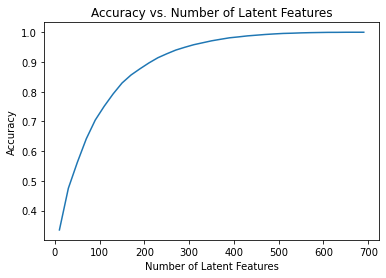

In [62]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/(df.shape[0]));
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

3. From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  


In [63]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    # train set
    df_train = df_train[['user_id', 'article_id']]
    df_train['value'] = 1
    df_train = df_train.groupby(['user_id', 'article_id']).max().unstack()
    df_train = df_train.fillna(0)
    user_item_train = df_train
    
    # test set
    df_test = df_test[['user_id', 'article_id']]
    df_test['value'] = 1
    df_test = df_test.groupby(['user_id', 'article_id']).max().unstack()
    df_test = df_test.fillna(0)
    user_item_test = df_test
    
    # user ids
    test_idx = user_item_test.index
    
    # article ids
    test_arts = user_item_test.columns.levels[1]
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [64]:
# common user ids in train and test set
common_idx = user_item_train.index.isin(test_idx)
common_idx.sum()

20

In [65]:
# users we cannot predict
len(test_idx) - common_idx.sum()

662

In [66]:
# common movie ids in train and test set
common_arts = user_item_train.columns.levels[1].isin(test_arts)
common_arts.sum()

574

In [67]:
# movies we cannot predict
len(test_arts) - common_arts.sum()

0

In [68]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, 
    'How many movies can we make predictions for in the test set?': b,
    'How many movies in the test set are we not able to make predictions for because of the cold start problem?': d
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test movies are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions 2 - 4.

4. Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [69]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train)# use the built in to get the three matrices

In [70]:
# Use these cells to see how well you can use the training 
# decomposition to predict on test data
train_ind = user_item_train.index[common_idx]
test_ind = user_item_test.index.isin(train_ind)
test_ind = user_item_test.index[test_ind]
test_ind == train_ind

user_item_test.loc[test_ind]

u_test = u_train[common_idx, :]
vt_test = vt_train[:, common_arts]

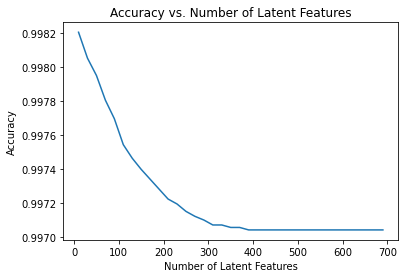

In [73]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
    u_test_new, vt_test_new = u_test[:, :k], vt_test[:k, :]
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_test_new, s_new), vt_test_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_test.loc[test_ind], user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/(df.shape[0]*df.shape[1]));
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

Use the cell below to comment on the results you found in the previous question. Given the circumstances of the results, is this an improvement on how the previous systems operated?

**Performance Review.**

The performance of the SVD becomes worse as the amount of latent features increases and this is due to overfitting.

The amount of common users between the train and test dataset is so few that it is not recommended to use SVD to predict the test dataset and knowledge based or content based approaches could be deployed for this cold start problem.

We could deploy the current recommendation engine with an experiment to check if there is an increase in interaction between users and articles for two different groups of users in a A/B test experiment where one group sees the SVD recommendations and another group sees a cold start approach.

The metric to measure the success of the experiment will be the number of articles the user interacts with because that is the original concept of the model built. The original model doesnt account for time spent on an article by a user.

In [74]:
# Save notebook
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])

1